https://arxiv.org/abs/2310.11511

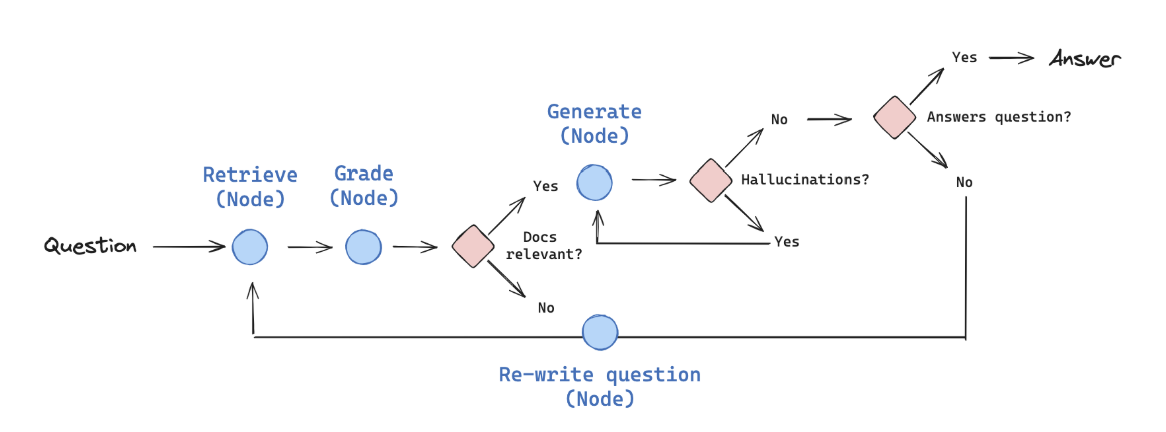

In [47]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})


In [48]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [49]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']  
    docs = retriever.invoke(query)  
    return {'context': docs}  


In [50]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [51]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    context = state['context']  
    query = state['query']      
    
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response.content}  


/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단
    - 문서와 관련이 없다면 질문에 답변할 수 없다고 판단하고 마무리
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성

In [52]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']  
    context = state['context']  

    doc_relevance_chain = doc_relevance_prompt | llm
    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [53]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    query = state['query']  
    
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}


- 답변이 `retrieve` 노드에서 추출된 문서와 관련이 있는지 판단
    - 문서와 관련이 없다면 `generate` 노드로 이동해서 답변을 다시 생성
    - 문서와 관련이 있다면 `check_helpfulness` 노드로 이동해서 답변이 도움이 되는지 판단

In [54]:
from langchain_core.prompts import PromptTemplate

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on facts or not,  
Given facts, which are excepts from income tax law, and a student's answer;                         
If the student's answer is based on documents, resond with "not hallucinated"
If the student's answer is not based on documents, resond with "hallucinated"

documents : {documents}
student_answer : {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']  
    context = state['context']
    context = [doc.page_content for doc in context]

    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    
    response = hallucination_chain.invoke({"student_answer": answer, "documents": context})
    
    return response

In [55]:
query = "연봉이 5천만원인 거주자의 소득세는 얼마인가요?"
context = retriever.invoke(query)

print("document start")
for document in context:
    print(document.page_content)
print("document end")

generate_state = {"query": query, "context": context}
answer = generate(generate_state)
print(f"answer == {answer}")

hallucination_state = {"answer": answer, "context": context}

check_hallucination(hallucination_state)



document start
[전문개정 2014. 1. 1.]
제56조 세액의 계산
<개정 2009. 12. 31.>  
제1관 세율
<개정 2009. 12. 31.>
제55조(세율)
거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.> 
| 종합소득           | 세    목                                          |
|------------------|--------------------------------------------------|
| 1,400만원 이하    | 과세표준의 6세부세트                               |
| 1,400만원 초과    | 84만원 + (1,400만원을 초과하는 금액의 15세부세트) |
| 5,000만원 이하    | 624만원 + (5,000만원을 초과하는 금액의 24세부세트) |
| 8,800만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35세부세트) |
| 1억5천만원 이하   | 3,706만원 + (1억5천만원을 초과하는 금액의 38세부세트) |
| 3억 원 이상       | 9,406만원 + (3억원을 초과하는 금액의 40세부세트) |
| 5억 원 이하       | 1억7,406만원 + (5억원을 초과하는 금액의 42세부세트) |
| 10억 원 이상      | 3억6,406만원 + (10억원을 초과하는 금액의 45세부세트) |
법제처 35
국가법령정보센터
소 트 실 변
② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다.)으로 한다. <개정> 2013. 1. 1, 2014. 12. 23.>
1. 해혼 사망기간의 퇴직소득국세

'not hallucinated'


- 생성된 답변이 사용자의 질문과 관련이 있는지 판단
    - 질문과 관련이 있다면 사용자에게 답변을 리턴
    - 질문과 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경
        - `rewrite` 후 다시 `retrieve` 합니다
- `check_helpfulness` node를 생성하지 않고 `check_helpfulness_grader`만 추가해서 conditional_edge로 사용

In [56]:
from langchain import hub

helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> Literal['helpful', 'unhelpful']:
    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfulness_prompt | llm

    response = helpfulness_chain.invoke({"question": query, "student_answer": answer})
    print(f"helpfulness response : {response}")

    if response["Score"] == 1:
        return "helpful"
    return "unhelpful"

def check_helpfulness(state: AgentState) -> AgentState:
    return state

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- node를 추가하고 edge로 연결

In [57]:
query = "연봉이 5천만원인 거주자의 소득세는 얼마인가요?"
context = retriever.invoke(query)

generate_state = {"query": query, "context": context}
answer = generate(generate_state)
print(f"answer == {answer}")

helpfulness_state = {"query": query, "answer": answer}

check_helpfulness(helpfulness_state)



answer == {'answer': '연봉이 5천만원인 거주자의 소득세는 624만원입니다. 이는 종합소득 과세표준으로 5천만원 이하에는 624만원의 세액을 적용한다고 명시되어 있습니다.'}


{'query': '연봉이 5천만원인 거주자의 소득세는 얼마인가요?',
 'answer': {'answer': '연봉이 5천만원인 거주자의 소득세는 624만원입니다. 이는 종합소득 과세표준으로 5천만원 이하에는 624만원의 세액을 적용한다고 명시되어 있습니다.'}}

In [58]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_doc_relevance", check_doc_relevance)
graph_builder.add_node("check_hallucination", check_hallucination)
graph_builder.add_node("check_helpfulness", check_helpfulness)

In [59]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve",
    check_doc_relevance,
    {
        "relevant": "generate",
        "irrelevant": END
    }
)
graph_builder.add_conditional_edges(
    "generate",
    check_hallucination,
    {
        "not hallucinated": "check_helpfulness",
        "hallucinated": "generate"
    }
)
graph_builder.add_conditional_edges(
    "check_helpfulness",
    check_helpfulness_grader,
    {
        "helpful": END,
        "unhelpful": "rewrite"
    }
)

graph_builder.add_edge("rewrite", "retrieve")

In [60]:
graph = graph_builder.compile()

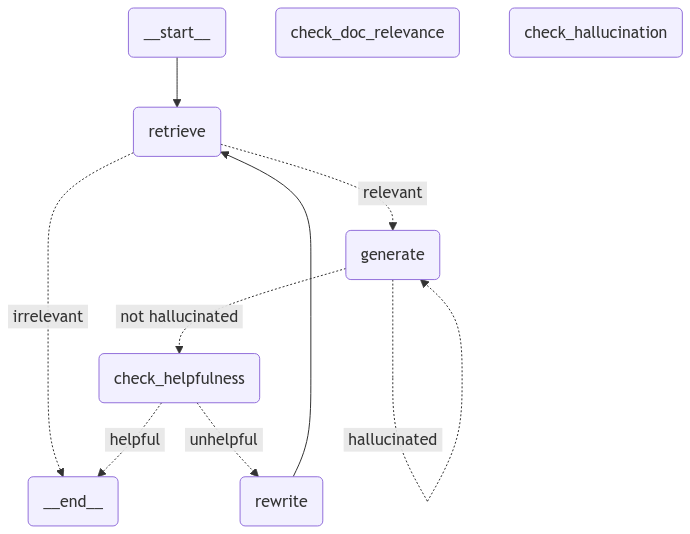

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
initial_state = {"query": "배고파"}
graph.invoke(initial_state)

{'query': '배고파',
 'context': [Document(id='39cf97f4-6a38-4d13-9038-40ec09b37c3e', metadata={'source': './documents/income_tax.txt'}, page_content='삭제<2012. 1. 1.>\n삭제<2012. 1. 1.>'),
  Document(id='08dc5aa3-7567-4d29-910c-33bca089068a', metadata={'source': './documents/income_tax.txt'}, page_content='제163조(계산서의 작성·발급 등) ① 제168조에 따라 사업자가 재화 또는 용역을 공급하는 경우에는 대표등록을 정하는 바에 따라 계산서(‘계산서’라 한다)를 작성하여 재화 또는 용역을 공급받는 자에게 발급하여야 한다. 이 경우 다음 각 호의 어느 하나에 해당하는 계산서를 발급할 때에는 대등형으로 정하는 전자적 방법으로 작성한 계산서에 비해 ‘전자계산서’란 이름을 붙여야 한다.<개정 2014. 12. 23.>'),
  Document(id='8a7def27-c304-4b1d-98a4-c6921ceac4ca', metadata={'source': './documents/income_tax.txt'}, page_content='제125조제1항에 해당하는 기타소득  \n\n제1항에 따라 가자기사업체를 제출해야 하며, 간이기사업체의 지배 사항을 국세기본법, 제2조 제18조에 따른 정보통신을 통해 제세해가니 다수 전자국적메일에 제출하여 한다. 이 경우 제출하고자 하는 소득 중 대통령령으로 정하는 방법을 통해서 제세할 수 있다.<개정> 2021. 3. 16.>  \n규정상 제2조의 규정으로 모두 해주어 고는 하며 임원 등분에 해당하는 자에게는 간이기사업체로 제세할 수 있다.<개정> 2021. 3. 16.>  \n제정부문에 제3탁까지의 규정에 따라 가자기사업체의 제출에 필요한 대통령령으로 정하여 한다.<개정> 2021. 3. 16.>\n[본설

In [63]:
initial_state = {"query": "연봉 5천만원인 거주자의 소득세는 얼마인가요?"}
graph.invoke(initial_state)

helpfulness response : {'Score': 1, 'Explanation': "The student's answer directly and correctly addresses the question regarding the income tax for a resident with a salary of 50 million won. The answer states that the income tax is 6.24 million won. Additionally, the student explains why no additional progressive tax set is applied, which is relevant to the explanation. The response is concise and provides a clear and relevant answer to the question, thus meeting all grading criteria."}


{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='21eb49d8-11d2-4b4f-b03b-0780eea295ec', metadata={'source': './documents/income_tax.txt'}, page_content='[전문개정 2014. 1. 1.]\n제56조 세액의 계산\n<개정 2009. 12. 31.>  \n제1관 세율\n<개정 2009. 12. 31.>\n제55조(세율)\n거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.> \n| 종합소득           | 세    목                                          |\n|------------------|--------------------------------------------------|\n| 1,400만원 이하    | 과세표준의 6세부세트                               |\n| 1,400만원 초과    | 84만원 + (1,400만원을 초과하는 금액의 15세부세트) |\n| 5,000만원 이하    | 624만원 + (5,000만원을 초과하는 금액의 24세부세트) |\n| 8,800만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35세부세트) |\n| 1억5천만원 이하   | 3,706만원 + (1억5천만원을 초과하는 금액의 38세부세트) |\n| 3억 원 이상       | 9,406만원 + (3억원을 초과하는 금액의 40세부세트) |\n| 5억 원 이하       | 1억7,406만원 + (5억원을 초과하는 금액의 42세부세트) |\n| 10억 원 이상      | 3억6,406만원 + (